## __Introduction__
The data is about BCC customer (Users, Services, Date the customers used the services). This project is inspired by Augustisme via her personal project on Kaggle: 
https://www.kaggle.com/augustisme/bbc-customer-analysis/notebook  
The goal is try to find out if the BBC ages belong to different serviceid clusters, and how we do cross-sale to customers.

## __Data Description__
There is one table data with three columns: User_id, Serviceid and Date.
- __User_id__ : the identity of the individual BBC customer.
- __Serviceid__: the identity of the transactions.
- __Date__: the date that transaction is executed.

## __Business questions__:
__1. Determine whether customers in different BBC ages have different serviceid cluster?__  
__2. We would like to know which serviceid we can cross-sales to users?__

### Importing library

In [3]:
# Data processing
import numpy as np
import pandas as pd
import datetime as dt
import functools

# Data Visualizing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data modeling
from mlxtend.frequent_patterns import apriori, association_rules,fpgrowth

# Warning Removal
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

### Import data

In [4]:
df = pd.read_csv('/mnt/c/ubuntu_ws/learning/data-analysis/BBC-analysis/data/BBC.csv')

In [5]:
first_column = df.pop('User_id')
df.insert(0, 'User_id', first_column)
df.head()

,User_id,Serviceid,Date
0,40709217,20,2-Jan-18
1,40709217,20,2-Jan-18
2,18246539,984,22-Mar-18
3,18246539,269,22-Mar-18
4,18246539,666,1-Apr-18


In [6]:
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
data_features = df.columns
def get_description(df, data_features):
    print(f"Number of rows: {len(df)}, number of columnns: {len(data_features)}")
    print(f"Number of features: {len(data_features)-1}")
    print(f"Number of infinite values: {np.isinf(df).sum().sum()}")
    print(f"Number of missing values: {df.isna().sum().sum()}")
    print(f"number of User_id: {df.User_id.nunique()}")
    print(f"Number of Servicedid: {df.Serviceid.nunique()}")

In [8]:
df.info()
get_description(df, data_features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1733 entries, 0 to 1732
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   User_id    1733 non-null   int64         
 1   Serviceid  1733 non-null   int64         
 2   Date       1733 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 40.7 KB
Number of rows: 1733, number of columnns: 3
Number of features: 2
Number of infinite values: 0
Number of missing values: 0
number of User_id: 44
Number of Servicedid: 79


The data contains 1733 observations, the number of records are the same in three columns; therefore, there is no missing values in the dataset.

In [9]:
df.head()

,User_id,Serviceid,Date
0,40709217,20,2018-01-02
1,40709217,20,2018-01-02
2,18246539,984,2018-03-22
3,18246539,269,2018-03-22
4,18246539,666,2018-04-01


In order to answer the two business questions, we have to convert the dataframe into a new one with more features namely Firstserviceid, FirstServiceDate, SecondServiceid, SecondServiceDate, LastServiceid, LastServiceDate and TotalService.  
- __Firstserviceid__: the first service used by a particular customer.   
     
- __FirstServiceDate__: the date that customer used the first service.
- __SecondServiceid__: the second service used by a particular customer.
- __SecondServiceDate__: the date that customer used the second service.
- __LastServiceid__: the last service used by a particular customer.
- __LastServiceDate__: the date that customer used the last service.  
- __TotalService__: the number of services this customer used.

The transform process have done via SQL Sever, all the code is showed below. 


Import the convert data

In [10]:
df2 = pd.read_csv("/mnt/c/ubuntu_ws/learning/data-analysis/BBC-analysis/data/BBC_FirstLast.csv")

In [11]:
df2.head()

,Unnamed: 0,User_id,TotalService,FirstServiceid,FirstServiceDate,SecondServiceid,SecondServiceDate,LastServiceid,LastServiceDate
0,0,2464231,10,18.0,2018-01-07,667.0,2018-01-16,982.0,2018-07-23
1,1,3676235,9,273.0,2018-01-05,481.0,2018-01-06,355.0,2018-04-12
2,2,4958104,7,946.0,2018-01-22,310.0,2018-01-22,268.0,2018-06-30
3,3,11642209,14,20.0,2018-01-01,666.0,2018-01-02,666.0,2018-06-29
4,4,18246539,4,984.0,2018-03-22,269.0,2018-03-22,666.0,2018-04-01


In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         44 non-null     int64  
 1   User_id            44 non-null     int64  
 2   TotalService       44 non-null     int64  
 3   FirstServiceid     44 non-null     float64
 4   FirstServiceDate   44 non-null     object 
 5   SecondServiceid    44 non-null     float64
 6   SecondServiceDate  44 non-null     object 
 7   LastServiceid      44 non-null     float64
 8   LastServiceDate    44 non-null     object 
dtypes: float64(3), int64(3), object(3)
memory usage: 3.2+ KB


In [13]:
#Merge df1 and df2 into one datafram dfs for further analysis
dfs = [df, df2]
CustomerData = functools.reduce(lambda left,right: pd.merge(left,right,on='User_id', how='outer'), dfs)
CustomerData.dropna(inplace = True)
CustomerData.head()

,User_id,Serviceid,Date,Unnamed: 0,TotalService,FirstServiceid,FirstServiceDate,SecondServiceid,SecondServiceDate,LastServiceid,LastServiceDate
0,40709217,20,2018-01-02,15,1,20.0,2018-01-02,20.0,2018-01-02,20.0,2018-01-02
1,40709217,20,2018-01-02,15,1,20.0,2018-01-02,20.0,2018-01-02,20.0,2018-01-02
2,18246539,984,2018-03-22,4,4,984.0,2018-03-22,269.0,2018-03-22,666.0,2018-04-01
3,18246539,269,2018-03-22,4,4,984.0,2018-03-22,269.0,2018-03-22,666.0,2018-04-01
4,18246539,666,2018-04-01,4,4,984.0,2018-03-22,269.0,2018-03-22,666.0,2018-04-01


Converting data to correct data types, especially the dtype of Date shold be converted into datatime64. 

In [14]:
def convert_time(x):
    return pd.to_datetime(x)

In [15]:
CustomerData['Date'] = CustomerData['Date'].map(convert_time)
CustomerData['FirstServiceDate'] = CustomerData['FirstServiceDate'].map(convert_time)
CustomerData['SecondServiceDate'] = CustomerData['SecondServiceDate'].map(convert_time)
CustomerData['LastServiceDate'] = CustomerData['LastServiceDate'].map(convert_time)
CustomerData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1733 entries, 0 to 1732
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   User_id            1733 non-null   int64         
 1   Serviceid          1733 non-null   int64         
 2   Date               1733 non-null   datetime64[ns]
 3   Unnamed: 0         1733 non-null   int64         
 4   TotalService       1733 non-null   int64         
 5   FirstServiceid     1733 non-null   float64       
 6   FirstServiceDate   1733 non-null   datetime64[ns]
 7   SecondServiceid    1733 non-null   float64       
 8   SecondServiceDate  1733 non-null   datetime64[ns]
 9   LastServiceid      1733 non-null   float64       
 10  LastServiceDate    1733 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(3), int64(4)
memory usage: 162.5 KB


## __Question 1:__
__Determine whether customers in different BBC ages have different serviceid cluster?__ 
 
To answer the question, we firstly define the "BBC_ages" variable.  
- __BBC_age__: the difference between the first date and the last date a particular customer using the service.

In [16]:
CustomerData['BBC_age'] = 1 + (CustomerData['LastServiceDate'] - CustomerData['FirstServiceDate']).dt.days

Text(0, 0.5, 'number of customers')

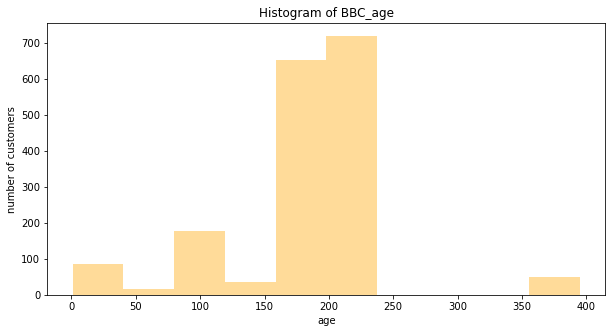

In [17]:
#seaborn histogram of BBC_age

plt.figure(figsize=(10,5))
sns.distplot(CustomerData['BBC_age'],hist = True, kde = False,
            bins = 10, color ='orange')
        
# Add labels
plt.title('Histogram of BBC_age')
plt.xlabel('age')
plt.ylabel('number of customers')

Based on the histogram above, the range of BBC ages are under 400 days; therefore, we decided to devide BBC_age into 4 bins:  
- 0 to 100  
- 101 to 200  
- 201 to 300 
- over 300

In [18]:
# Spliting customers into 4 categories 
 
bins = [0, 100, 200, 300, np.inf]
names = ['100_BBC_age', '200_BCC_age', '300_BBC_age', '300_plus_BBC_age']
CustomerData['Age_bin'] = pd.cut(CustomerData['BBC_age'], bins, labels=names)

In [19]:
CustomerData.head()

,User_id,Serviceid,Date,Unnamed: 0,TotalService,FirstServiceid,FirstServiceDate,SecondServiceid,SecondServiceDate,LastServiceid,LastServiceDate,BBC_age,Age_bin
0,40709217,20,2018-01-02,15,1,20.0,2018-01-02,20.0,2018-01-02,20.0,2018-01-02,1,100_BBC_age
1,40709217,20,2018-01-02,15,1,20.0,2018-01-02,20.0,2018-01-02,20.0,2018-01-02,1,100_BBC_age
2,18246539,984,2018-03-22,4,4,984.0,2018-03-22,269.0,2018-03-22,666.0,2018-04-01,11,100_BBC_age
3,18246539,269,2018-03-22,4,4,984.0,2018-03-22,269.0,2018-03-22,666.0,2018-04-01,11,100_BBC_age
4,18246539,666,2018-04-01,4,4,984.0,2018-03-22,269.0,2018-03-22,666.0,2018-04-01,11,100_BBC_age


Text(0, 0.5, 'Total sevices')

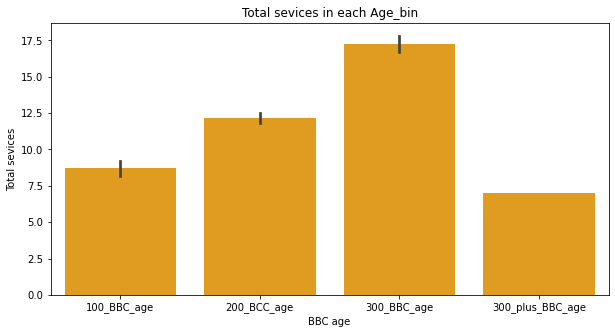

In [20]:
#seaborn histogram of total sevices in each Age_bin

plt.figure(figsize=(10,5))
sns.barplot(CustomerData['Age_bin'],CustomerData['TotalService'], color ='orange')

plt.title('Total sevices in each Age_bin')
plt.xlabel('BBC age')
plt.ylabel('Total sevices')

We can see that BBC customers, who are in the age bin of 300, show the highest service use frequency compared to other age bins.  

In the follwing step, we will group and count the number of customers based on Age_bin and Serviceid in order to illustrate what services are used most by each group.

In [21]:
agg = CustomerData.groupby(['Age_bin','Serviceid'])[['User_id']].count().dropna()
pd.DataFrame(agg['User_id'].groupby(level = 0, group_keys= False).nlargest(5)).style.background_gradient(cmap='Blues')

From above analysis, we can see that:  

- Customers in 100_BBC_age group tend to use Serviceid of 667, 333, 1014, 487, 981.  
- Customers in 200_BBC_age group tend to use Serviceid of 981, 20, 1014, 271, 666.  
- Customers in 300_BBC_age group tend to use Serviceid of 18, 333, 667, 981, 268.  
- Customers in 300_plus_BBC_age group tend to use Serviceid of 981,19, 271, 1014, 2.


In [22]:
TopServices = CustomerData.groupby('Serviceid')['User_id'].nunique().sort_values(ascending = False)
TopServices = pd.DataFrame(TopServices).reset_index()
TopServices = TopServices.set_axis(["Serviceid", "Count"], axis=1)

In [23]:
TopServices

,Serviceid,Count
0,1014,27
1,981,25
2,271,20
3,268,16
4,667,15
...,...,...
74,327,1
75,330,1
76,355,1
77,456,1


Text(0.5, 1.0, 'Service use distribution')

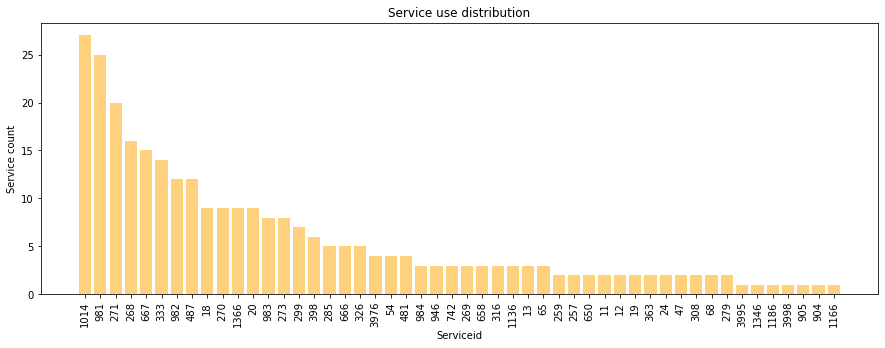

In [24]:
# Visualize top used sevices

objects = (list(TopServices['Serviceid'].head(50)))
y_pos = np.arange(len(objects))
performance = list(TopServices['Count'].head(50))


plt.figure(figsize=(15,5)) 
plt.bar(y_pos, performance, align='center', alpha=0.5, color ='orange')
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Service count')
plt.xlabel('Serviceid')
plt.title('Service use distribution')

## __Question 2__

__We would like to know which serviceid we can cross-sell to users?__  



First, we need to understand what is cross-selling:  
 
__Cross-selling__ is the practice of selling additional products to existing customers, often practiced in the financial services industry. (investopedia)

To find out which service we can cross-sell for a particular customer, we define a transaction table, which including all transactions that each customer executes during a day. This table shows items (services) customers ussally buy along with other services, we define these items as a combo.  

Therefore, the CustomerData table should be transformed to a new table with a __"User_id & Date"__ column, which is a combinantion of the two columns: __"User_id"__ and __"Date"__.  

__"User_id & Date"__ : is considered as Transaction of customers

In [25]:
Transaction = CustomerData[['User_id', 'Date']]
Transaction['User_id & Date'] = Transaction['User_id'].astype('str') + ' | ' + Transaction['Date'].astype('str')
Transaction = Transaction.drop(Transaction[['User_id','Date']], axis = 1)
Transaction['Serviceid'] = CustomerData['Serviceid']

In [26]:
Transaction.head(6)

,User_id & Date,Serviceid
0,40709217 | 2018-01-02,20
1,40709217 | 2018-01-02,20
2,18246539 | 2018-03-22,984
3,18246539 | 2018-03-22,269
4,18246539 | 2018-04-01,666
5,18246539 | 2018-04-01,326


In [27]:
ComboTransaction = pd.crosstab(Transaction['User_id & Date'], Transaction['Serviceid'])
ComboTransaction = ComboTransaction.reset_index()
ComboTransaction.columns = ['Serviceid ' + str(col) for col in ComboTransaction.columns]
ComboTransaction = ComboTransaction.set_index('Serviceid User_id & Date')
ComboTransaction.head(3)

,Serviceid 2,Serviceid 4,Serviceid 10,Serviceid 11,Serviceid 12,Serviceid 13,Serviceid 18,Serviceid 19,Serviceid 20,Serviceid 23,...,Serviceid 1136,Serviceid 1166,Serviceid 1186,Serviceid 1346,Serviceid 1366,Serviceid 3976,Serviceid 3995,Serviceid 3998,Serviceid 4095,Serviceid 4483
Serviceid User_id & Date,,,,,,,,,,,,,,,,,,,,,
11642209 | 2018-01-01,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11642209 | 2018-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11642209 | 2018-01-03,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


After converting the CustomerData table to a suitable dataframe, we apply Apriori algorithm to detect the cross-selling services based on 3 evaluation metrics:  
- Confidence  
- Support  
- Lift  
 
The Apriori algorithm is one of Machine learning methods, which uses breadth-first search to develop and enables efficient extraction of Association Rules from a list of transactions.

In [28]:
# Defining the hot encoding function to make the data suitable
# for the concerned libraries
def hot_encode(x):
    if(x < 0 or x == 0):
        return 0
    if(x > 0 or x == 1):
        return 1


# Encoding the datasets
Baskets = ComboTransaction.applymap(hot_encode)
Baskets.head(3)

,Serviceid 2,Serviceid 4,Serviceid 10,Serviceid 11,Serviceid 12,Serviceid 13,Serviceid 18,Serviceid 19,Serviceid 20,Serviceid 23,...,Serviceid 1136,Serviceid 1166,Serviceid 1186,Serviceid 1346,Serviceid 1366,Serviceid 3976,Serviceid 3995,Serviceid 3998,Serviceid 4095,Serviceid 4483
Serviceid User_id & Date,,,,,,,,,,,,,,,,,,,,,
11642209 | 2018-01-01,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11642209 | 2018-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11642209 | 2018-01-03,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## __Emplementing algorithms__

### Building the model with Apriori algorithm

In [29]:
# Building the model with Apriori algorithm
import time 
start_ap = time.time()

frq_items_ap = apriori(Baskets, min_support = 0.05, use_colnames = True)

end_ap = time.time()

frq_items_ap['element'] = frq_items_ap['itemsets'].apply(lambda x : len(x))
frq_items_ap[(frq_items_ap['element']) > 1].head(6)

,support,itemsets,element
13,0.072954,"(Serviceid 333, Serviceid 13)",2
14,0.072954,"(Serviceid 13, Serviceid 667)",2
15,0.074733,"(Serviceid 268, Serviceid 18)",2
16,0.096085,"(Serviceid 981, Serviceid 18)",2
17,0.076512,"(Serviceid 18, Serviceid 982)",2
18,0.060498,"(Serviceid 18, Serviceid 1014)",2


In [30]:
rules = association_rules(frq_items_ap, metric="lift", min_threshold=1)
results = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values('support', ascending=False)
results[(results['lift'] > 1) & results['confidence'] > 0.8].head(10)

,antecedents,consequents,support,confidence,lift
23,(Serviceid 667),(Serviceid 333),0.199288,0.918033,4.606557
22,(Serviceid 333),(Serviceid 667),0.199288,1.000000,4.606557
25,(Serviceid 1014),(Serviceid 981),0.170819,0.793388,2.876673
24,(Serviceid 981),(Serviceid 1014),0.170819,0.619355,2.876673
16,(Serviceid 268),(Serviceid 982),0.113879,0.927536,8.019621
17,(Serviceid 982),(Serviceid 268),0.113879,0.984615,8.019621
21,(Serviceid 326),(Serviceid 666),0.101423,1.000000,9.525424
20,(Serviceid 666),(Serviceid 326),0.101423,0.966102,9.525424
19,(Serviceid 981),(Serviceid 271),0.101423,0.367742,2.952442
18,(Serviceid 271),(Serviceid 981),0.101423,0.814286,2.952442


In [31]:
print(f'runtime: {end_ap - start_ap}')

runtime: 0.014522790908813477


### Building the model with Fpgrowth algorithm

In [32]:
# Building the model with Fpgrowth algorithm
start_fp = time.time()

frq_items_fp = fpgrowth(Baskets, min_support=0.05, use_colnames=True)

end_fp = time.time()

frq_items_fp['element'] = frq_items_fp['itemsets'].apply(lambda x : len(x))
frq_items_fp[(frq_items_fp['element']) > 1].head(6)

,support,itemsets,element
13,0.058719,"(Serviceid 20, Serviceid 666)",2
14,0.101423,"(Serviceid 666, Serviceid 326)",2
15,0.058719,"(Serviceid 20, Serviceid 326)",2
16,0.058719,"(Serviceid 20, Serviceid 666, Serviceid 326)",3
17,0.074733,"(Serviceid 268, Serviceid 18)",2
18,0.113879,"(Serviceid 268, Serviceid 982)",2


In [33]:
# creating asssociation rules
rule2 = association_rules(frq_items_fp, metric = "lift", min_threshold=1)
rule2 = rule2[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values('support', ascending=False)
rule2[(rule2['lift'] > 1) & rule2['confidence'] > 0.8].head(10)

,antecedents,consequents,support,confidence,lift
27,(Serviceid 667),(Serviceid 333),0.199288,0.918033,4.606557
26,(Serviceid 333),(Serviceid 667),0.199288,1.000000,4.606557
25,(Serviceid 1014),(Serviceid 981),0.170819,0.793388,2.876673
24,(Serviceid 981),(Serviceid 1014),0.170819,0.619355,2.876673
14,(Serviceid 268),(Serviceid 982),0.113879,0.927536,8.019621
15,(Serviceid 982),(Serviceid 268),0.113879,0.984615,8.019621
39,(Serviceid 981),(Serviceid 271),0.101423,0.367742,2.952442
2,(Serviceid 666),(Serviceid 326),0.101423,0.966102,9.525424
3,(Serviceid 326),(Serviceid 666),0.101423,1.000000,9.525424
38,(Serviceid 271),(Serviceid 981),0.101423,0.814286,2.952442


In [34]:
print(f'runtime {end_fp - start_fp}')

runtime 0.015557527542114258
